#  Network based statistic (NBS)

(Modified from https://github.com/oercompbiomed/CBM101/tree/master/D_Network_analysis by Peder Lillebostad)

Performing statistical tests on brain networks.

#### Reading

- Zalesky et al. _Network-based statistic: Identifying differences in brain networks_. Neuroimage 2010;53(4):1197-1207. [[PDF](./assets/Zalesky_etal_NBS_Neuroimage_2010.pdf)]
- van den Heuvel & Sporns. _Network hubs in the human brain_. Trends in Cognitive Sciences 2013;17(12):683-696. [[PDF](./assets/van_den_Heuvel_Sporns_Network_hubs_TICS_2013.pdf)]
- Rubinov & Sporns. _Complex network measures of brain connectivity: Uses and interpretations_. Neuroimage 2010;52:1059–1069. [[PDF](./assets/Rubinov_Sporns_Complex_network_measures_Neuroimage_2010.pdf)]
- Huber et al. _Layer-dependent functional connectivity methods_. Progress in Neurobiology; Available online 5 June 2020, 101835. [[PDF](./assets/Huber_etal_Layer_dependent_functional_connectivity_methods_Progress_in_Neurobiol_2020.pdf)]
> Data and software availability (**layer fMRI**):<br>
Anonymized MRI data that are presented in this article can be anonymously downloaded from OpenNeuro. Volume maps of data presented in Fig. 2 can be downloaded at http://doi.org/10.18112/openneuro.ds002274.v1.0.2 (go to actualfiles/V1_LAYERING). The raw and processed data of multiple participants of the study shown in Fig. 4, Fig. 6 are available here: www.doi.org/10.18112/openneuro.ds001547.v1.1.0. Data shown in Fig. 5, Fig. 8 are publicly available from previous published studies (Huber et al., 2017). Underlying tables and lists used for Fig. 10 are available on https://layerfmri.com/VASOworldwide. All custom written software (source code) and evaluation scripts are available on Github (https://github.com/layerfMRI/repository). The authors are happy to share the MAGEC-VASO 3D-EPI MR sequence upon request via a SIEMENS C2P agreement. A complete list of scan parameters used in this study is available on Github (https://github.com/layerfMRI/Sequence_Github). The source code of the layer-specific analysis software is available on Github (https://github.com/layerfMRI/LAYNII) with analysis pipelines explained on www.layerfmri.com. All stimulation presentations were implemented in Psychopy and can be downloaded here: https://github.com/layerfMRI/Phychopy_git.


### Preparation:
Unfortunately for legal reasons, in order to complete this notebook you must gain access to make an account on  https://db.humanconnectome.org/ to access the data. This requires `IBM Aspera Connect`, a plugin to access the data (you will be prompted by a pop-up from the website). 

* Once you have created an account, gain access to the HCP1200 dataset
https://db.humanconnectome.org/data/projects/HCP_1200#HcpOpen

* Go under **HCP1200 Parcellation+Timeseries+Netmats (PTN)** and download the 10 GB `812 Subjects, recon r227 only, PTN Release` zip file.

* Under **Quick Downloads** (left hand side) download the Behavioural data (csv file).


> - Once downloaded, unzip the folder.
> - untar the move the file `netmats_3T_HCP1200_MSMAll_ICAd100_ts2.tar.gz` in git bash using `tar -xzvf <filename>`
> - this creates a directory `netmats`. Open this and select the file netmats1.txt and move it to the data subdirectory and rename it to `ICA_d100_netmats.txt`
> - rename the behavioural data to `behavioural.csv`.
> - Move all the relevant files plus `subjectsID_recon2.txt` to the data subdirectory.



## The concept behind NBS

Network-based statistic is a non-parametric permutation test used to assess whether the connectomes of two populations are different.

#### What is a permutation test?

What all statistical tests have in common is that they calculate some number (a test statistic) from the data, and compare it to the null distribution. If the test statistic deviates more from this than what we can reasonably expect under the null hypothesis, we say there is an effect.

The only difference in a permutation test is that we don't need to make assumptions about the null distribution (i.e. non-parametric), but we find it using random assignments of the labels. The basic steps is to compute the test-statistic, then randomly shuffle the labels (e.g. sick versus patient) and recompute the statistic. You repeat this reshuffling/recomputing a large number of times to get the null distribution. If the first ("real") test-statistic significantly differs from the expected null distribution, we likely have a population difference.

[The original paper](https://www.sciencedirect.com/science/article/abs/pii/S1053811910008852)


__The steps of NBS are straight forward:__

1. For each edge of the network, perform a statistical test (two-sided t-test) for whether it is different between the two populations. This yields a single number for each edge.


2. Construct a pseudo-network where the above t-stats are used as the edges of the pseudo-network. The resulting graph can be thought of the "difference network" between the two populations.


2. Choose a threshold (usually you try multiple) and discard all the weights weaker than this threshold in the pseudo-network. This results in a fragmented network with components of variable size. Identify the largest connected component and write down its size (number of edges).


3. Identify the LARGEST connected component and write down its size (number of edges). This is your test-statistic. 


4. Randomly reassign the participants, and repeat step 1-3 *K* times (usually *K=1000*). Check for significance.


This image reviews the steps in a single iteration to compute the test statistic.
<img src="assets/nbs.png" alt="nbs steps" title="NBS steps" />

## Brain Connectivity Toolbox

#### Matlab (https://sites.google.com/site/bctnet)

#### Python (https://pypi.org/project/bctpy)

#### C++ (https://code.google.com/archive/p/bct-cpp/wikis/UsersGuide.wiki)

bct-cpp is a C++ port of the [Brain Connectivity Toolbox](https://sites.google.com/site/bctnet) (BCT), a set of MATLAB functions and neuroanatomical data sets useful in the analysis of structural or functional brain networks.

- Naturally, if you know C++, you can use bct-cpp.
- If you know (or prefer) Python, you can use bct-cpp to generate Python bindings. In general, your code will still run faster than the original MATLAB implementation, since the Python bindings use bct-cpp's compiled C++ code under the hood.
- If you know MATLAB (but not C++ or Python), you can't use bct-cpp. Download the MATLAB implementation of BCT instead.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [93]:
import sys
import os
import bct

import numpy as np
import pandas as pd
import networkx as nx

from bct import nbs
from matplotlib import pyplot as plt
from numpy.linalg import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler as scaler
from nilearn.plotting import plot_matrix

In [2]:
sys.executable

'/Users/arvid/opt/anaconda3/envs/bmed360v2021/bin/python'

NBS is implemented in the Brain Connectivity Toolbox for Python `bctpy`. If you don't have it already installed, uncomment and run the cell below.

In [3]:
import bct
from bct import nbs

In [4]:
#!{sys.executable} -m pip install bctpy

In [5]:
#verify installation
!conda list bctpy 

# packages in environment at /Users/arvid/opt/anaconda3/envs/bmed360v2021:
#
# Name                    Version                   Build  Channel
bctpy                     0.5.2                    pypi_0    pypi


### Proof of concept  with random simulated data

In [6]:
all_subjects = np.random.rand(15,15,50) # N=50, nodes=15
group1 = all_subjects[:,:,:25]
group2 = all_subjects[:,:,25:]

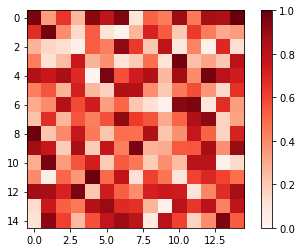

In [7]:
sub0 = group1[:,:,0] 
plt.imshow(sub0, cmap=plt.cm.Reds, vmin=0, vmax=1)
plt.colorbar()

Since we drew both groups out of the same population `all_subjects`, there should be no group difference between the two.

In [8]:
def do_nbs(g1, g2, kappa=0.8, plot=True, k=1000):
    pval, adj, null = nbs.nbs_bct(g1, g2, kappa, k=k)
    if plot:
        plt.hist(null, bins=20); plt.show()
    return pval, adj, null

In [9]:
pval, adj, null = do_nbs(group1, group2, plot=False)

max component size is 47
estimating null distribution with 1000 permutations
permutation 0 of 1000.  p-value so far is 1.000
permutation 100 of 1000.  p-value so far is 0.297
permutation 200 of 1000.  p-value so far is 0.353
permutation 300 of 1000.  p-value so far is 0.346
permutation 400 of 1000.  p-value so far is 0.347
permutation 500 of 1000.  p-value so far is 0.327
permutation 600 of 1000.  p-value so far is 0.326
permutation 700 of 1000.  p-value so far is 0.321
permutation 800 of 1000.  p-value so far is 0.322
permutation 900 of 1000.  p-value so far is 0.333
permutation 999 of 1000.  p-value so far is 0.337


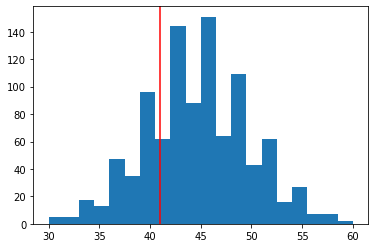

In [10]:
plt.hist(null, bins=20)
plt.axvline(41, c='red', )

**Conclusion:** the test statistic is well within the expected range under the null hypothesis, so we have no reason to assume a group difference. This is expected because we drew both groups from the same simulated population. Next we can use a real dataset from the Human Connectome Project (HCP1200) with some behavioural data to see if we have a difference based on certain traits.

# Testing it on a real dataset
We start by loading the behavioural data (metadata from which we can test variables of interest and filter based on exclusion criteria).

In [12]:
behav = pd.read_csv('data/behavioural.csv')

In [14]:
behav.head()

,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,100004,S900,Q06,M,22-25,False,0,0,0,0.0,...,5.2,101.12,86.45,2.0,45.9,107.17,105.31,1.80,0.0,1.80
1,100206,S900,Q11,M,26-30,True,1,1,4,100.0,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
2,100307,Q1,Q01,F,26-30,True,1,1,4,100.0,...,3.6,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76
3,100408,Q3,Q03,M,31-35,True,1,1,4,100.0,...,2.0,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68
4,100610,S900,Q08,M,26-30,True,2,1,4,100.0,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88


In [13]:
for col in behav.columns: print(col)

Subject
Release
Acquisition
Gender
Age
3T_Full_MR_Compl
T1_Count
T2_Count
3T_RS-fMRI_Count
3T_RS-fMRI_PctCompl
3T_Full_Task_fMRI
3T_tMRI_PctCompl
fMRI_WM_PctCompl
fMRI_Gamb_PctCompl
fMRI_Mot_PctCompl
fMRI_Lang_PctCompl
fMRI_Soc_PctCompl
fMRI_Rel_PctCompl
fMRI_Emo_PctCompl
3T_dMRI_Compl
3T_dMRI_PctCompl
dMRI_3T_ReconVrs
fMRI_3T_ReconVrs
7T_Full_MR_Compl
7T_RS-fMRI_Count
7T_RS-fMRI_PctCompl
7T_Full_Task_fMRI
7T_tMRI_PctCompl
fMRI_Movie_Compl
fMRI_Movie_PctCompl
fMRI_Ret_Compl
fMRI_Ret_PctCompl
7T_dMRI_Compl
7T_dMRI_PctCompl
7T_fMRI_Mov_Vrs
MEG_AnyData
MEG_FullProt_Compl
MEG_HeadModel_Avail
MEG_CortRibn_Avail
MEG_Anatomy_Avail
MEG_Anatomy_Compl
MEG_Noise_Avail
MEG_Noise_Compl
MEG_RS_Avail
MEG_RS_Compl
MEG_WM_Avail
MEG_WM_Compl
MEG_StoryMath_Avail
MEG_StoryMath_Compl
MEG_Motor_Avail
MEG_Motor_Compl
Non-TB_Compl
VisProc_Compl
DelDisc_Compl
SCPT_Compl
IWRD_Compl
PMAT_Compl
VSPLOT_Compl
EmoRecog_Compl
NEO-FFI_Compl
ASR-Syn_Compl
ASR-DSM_Compl
Toolbox_Compl
MMSE_Compl
PSQI_Compl
Alert_Compl
AS

We select only those who has completed all scanning sessions. We will use these indices to select the relevant matrices later.

In [14]:
ids = pd.read_csv('data/subjectIDs_recon2.txt', names=['Subject'])

In [15]:
print(ids.shape)
ids.head()

(812, 1)


,Subject
0,100206
1,100610
2,101006
3,101107
4,101309


In [16]:
print(behav.shape)
behav.head()

(1206, 582)


,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,100004,S900,Q06,M,22-25,False,0,0,0,0.0,...,5.2,101.12,86.45,2.0,45.9,107.17,105.31,1.80,0.0,1.80
1,100206,S900,Q11,M,26-30,True,1,1,4,100.0,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
2,100307,Q1,Q01,F,26-30,True,1,1,4,100.0,...,3.6,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76
3,100408,Q3,Q03,M,31-35,True,1,1,4,100.0,...,2.0,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68
4,100610,S900,Q08,M,26-30,True,2,1,4,100.0,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88


#### Exercise 1. Merge the dataframes on the `Subject` column, call the new dataframe `merged`.
This effectively selects only the 812 subjects from which we have data

In [18]:
# %load solutions/ex2_1.py
merged = pd.merge(ids, behav, on='Subject')

In [19]:
print(merged.shape)
merged.head()

(812, 582)


,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,100206,S900,Q11,M,26-30,True,1,1,4,100.0,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
1,100610,S900,Q08,M,26-30,True,2,1,4,100.0,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88
2,101006,S500,Q06,F,31-35,True,2,2,4,100.0,...,6.0,122.25,111.41,0.0,38.6,123.80,123.31,1.80,0.0,1.80
3,101107,S500,Q06,M,22-25,True,2,2,4,100.0,...,6.8,108.79,97.19,1.0,50.1,134.65,131.38,1.84,0.0,1.84
4,101309,S500,Q06,M,26-30,True,1,1,4,100.0,...,5.2,122.25,110.45,0.0,38.6,106.39,104.39,1.80,0.0,1.80


# load the network matrices

In [20]:
netmats = np.loadtxt('data/ICA_d100_netmats.txt')

In [21]:
netmats.shape # each row is a flattened adjacency matrix.

(812, 10000)

Rescale the data to 0 mean and 1 variance

In [22]:
scaler = StandardScaler()
netmats = scaler.fit_transform(netmats)

#### Exercise 2. "Resquare" the flattened matrices.
i.e. we want 812 100x100 matrices

In [25]:
# %load solutions/ex2_2.py
d = np.sqrt(netmats.shape[1]).astype(np.int)
print(d)
netmats = netmats.reshape(netmats.shape[0], d,d)

100


(812, 100, 100)


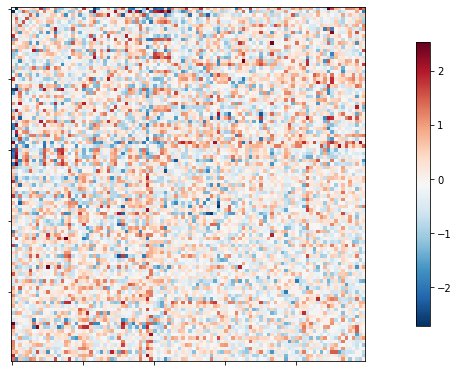

In [26]:
print(netmats.shape)
plot_matrix(netmats[60])
plt.show()

#### Exercise 3: Remove uninteresting covariates (make a new df containing only subject ID and gender).
We will stick to gender for the sake of simplicity

In [28]:
# %load solutions/ex2_3.py
merged = merged.loc[:,['Subject','Gender']]

In [29]:
merged.head()

,Subject,Gender
0,100206,M
1,100610,M
2,101006,F
3,101107,M
4,101309,M


In [30]:
merged.shape

(812, 2)

In [31]:
netmats.shape

(812, 100, 100)

#### Exercise 4. NAN values in dataframes are common and can cause trouble. Verify that there are no NANs in `merged`.

In [33]:
# %load solutions/ex2_4.py
# any NaNs?
np.any(merged.isna())

False

#### Exercise 5. Divide the data into two subdatasets (male and female)

In [34]:
merged.Gender

0      M
1      M
2      F
3      M
4      M
      ..
807    M
808    F
809    F
810    M
811    F
Name: Gender, Length: 812, dtype: object

In [35]:
female = netmats[merged.Gender=='F'].T 
male = netmats[merged.Gender=='M'].T

In [36]:
print('M: ', male.shape, '\nF: ', female.shape)

M:  (100, 100, 402) 
F:  (100, 100, 410)


#### Exercise 6. Problem: must have equally many subjects in each group. Remove enough subjects from one group until they are equal in numbers.

In [38]:
# %load solutions/ex2_6.py
# must be equal size
female = female[:,:,:male.shape[-1]]

In [39]:
print('M: ', male.shape, '\nF: ', female.shape)
male.shape == female.shape

M:  (100, 100, 402) 
F:  (100, 100, 402)


True

### Perform NBS (warning: will take some minutes)

In [40]:
male.T.shape

(402, 100, 100)

In [43]:
help(do_nbs)

Help on function do_nbs in module __main__:

do_nbs(g1, g2, kappa=0.8, plot=True, k=1000)



In [46]:
# https://stackoverflow.com/questions/16571150/how-to-capture-stdout-output-from-a-python-function-call
from io import StringIO 
import sys

class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout

Usage:
```
with Capturing() as output:
    do_something(my_object)
```
`output` is now a list containing the lines printed by the function call.

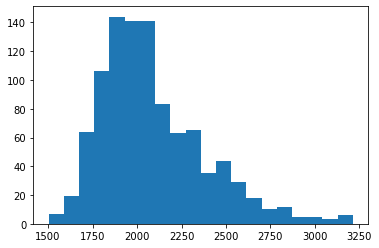

CPU times: user 5min 8s, sys: 389 ms, total: 5min 9s
Wall time: 5min 9s


In [48]:
%%time
# after correcting
with Capturing() as output:
    pval, adj, null = do_nbs(male, female, kappa=0.8)

```
max component size is 3876
estimating null distribution with 1000 permutations
permutation 0 of 1000.  p-value so far is 0.000
permutation 100 of 1000.  p-value so far is 0.000
permutation 200 of 1000.  p-value so far is 0.000
permutation 300 of 1000.  p-value so far is 0.000
permutation 400 of 1000.  p-value so far is 0.000
permutation 500 of 1000.  p-value so far is 0.000
permutation 600 of 1000.  p-value so far is 0.000
permutation 700 of 1000.  p-value so far is 0.000
permutation 800 of 1000.  p-value so far is 0.000
permutation 900 of 1000.  p-value so far is 0.000
permutation 999 of 1000.  p-value so far is 0.000
```

In [49]:
output

['max component size is 3876',
 'estimating null distribution with 1000 permutations',
 'permutation 0 of 1000.  p-value so far is 0.000',
 'permutation 100 of 1000.  p-value so far is 0.000',
 'permutation 200 of 1000.  p-value so far is 0.000',
 'permutation 300 of 1000.  p-value so far is 0.000',
 'permutation 400 of 1000.  p-value so far is 0.000',
 'permutation 500 of 1000.  p-value so far is 0.000',
 'permutation 600 of 1000.  p-value so far is 0.000',
 'permutation 700 of 1000.  p-value so far is 0.000',
 'permutation 800 of 1000.  p-value so far is 0.000',
 'permutation 900 of 1000.  p-value so far is 0.000',
 'permutation 999 of 1000.  p-value so far is 0.000']

In [55]:
# read from the print-out above
# max_comp_sz = 3876

max_comp_sz = int(output[0][22:])

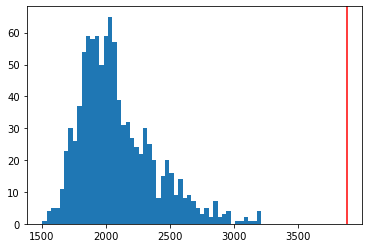

In [56]:
plt.hist(null, bins=50)
plt.axvline(max_comp_sz, c='r')
plt.show()

### Intrepretation
Exact p-values are inaccurate in permutation tests when very small, so we can increase the number of permutations (and append to the null distribution above) if you want a more precise estimate. However, from the results we can say that the p-value at least is < 0.001 (it might be much lower, but we only did 1000 permutations). It should also be specified that the p-value for any statistical test is not concerned with the magnitude of the difference, but rather a measure of the certainty of whether there *is* a difference at all, irrespective of its size. We used a large dataset (N=400), so discovering a difference was not surprising.

The identified difference is not pertained to a single locus but is based on a subnetwork of edges in the connectome, specifically:

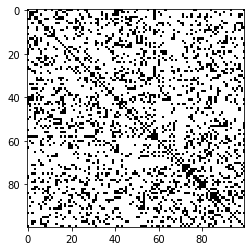

In [57]:
plt.imshow(adj, cmap='gray')
plt.show()

For those interested, one could download the cortical maps corresponding to the 100 regions from https://db.humanconnectome.org/, and plot the edges in question. However, the image above shows that the edges (white) cover the majority (80%) of the edges.

In [61]:
print('Graph density:')
bct.density_und(adj)

Graph density:


(0.7830303030303031, 100, 3876)

In [62]:
adj.sum() / (100*100-100)

0.7830303030303031

In [63]:
# read from the print-out above
#max_comp_sz = 3876


Furthermore, every node in the graph is included in the subnetwork, which can be dissapointing.
More interesting is to redo the NBS at a stricter threshold, narrowing down the subnetwork to its most important "core". However, beware that this kappa value has to be predefined to be statistically valid. Commonly one would decide on a range of e.g. 4 values, and run the test for each.

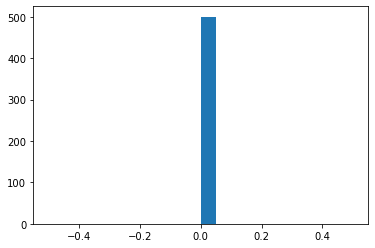

CPU times: user 2min 46s, sys: 404 ms, total: 2min 46s
Wall time: 2min 47s


In [58]:
%%time
# after correcting
with Capturing() as output2:
    pval2, adj2, null2 = do_nbs(male, female, kappa=6, k=500)

In [59]:
output2

['max component size is 170',
 'estimating null distribution with 500 permutations',
 'permutation 0 of 500.  p-value so far is 0.000',
 'permutation 50 of 500.  p-value so far is 0.000',
 'permutation 100 of 500.  p-value so far is 0.000',
 'permutation 150 of 500.  p-value so far is 0.000',
 'permutation 200 of 500.  p-value so far is 0.000',
 'permutation 250 of 500.  p-value so far is 0.000',
 'permutation 300 of 500.  p-value so far is 0.000',
 'permutation 350 of 500.  p-value so far is 0.000',
 'permutation 400 of 500.  p-value so far is 0.000',
 'permutation 450 of 500.  p-value so far is 0.000',
 'permutation 499 of 500.  p-value so far is 0.000']

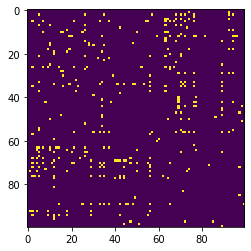

In [64]:
plt.imshow(adj2)
plt.show()

In [ ]:
bct.

In [66]:
bct.density_dir(adj2)

(0.03434343434343434, 100, 340)

[ 0.  2. 10.  1.  6. 12.  0.  6.  2.  4.  7.  1. 13.  1.  5.  3.  4.  0.
  6.  3.  3.  5.  2.  1.  1.  2. 10.  2.  2.  6.  3.  0.  1.  7.  9.  9.
  0.  5.  1.  1.  2.  2.  7.  0.  6.  2.  1.  3.  3.  2.  4.  1.  1.  1.
  1.  3. 13.  2.  0.  2.  1.  0.  1. 10.  5.  7.  0.  2.  7.  7. 12.  3.
  9.  2.  6.  0. 11.  5.  0.  0.  0.  1.  0.  1.  0.  1.  1.  0.  0. 13.
  0.  0.  7.  0.  8.  1.  1.  3.  2.  1.]


80

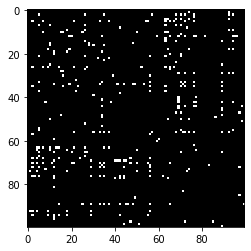

In [67]:
plt.imshow(adj2, cmap='gray')
# number of nodes included:
print(adj2.sum(axis=0))

# number of nodes included in the sub-network
n_nodes = np.sum(adj2.sum(axis=0) > 0)
n_nodes

**Degree functions** allow to determine nodes with a large number of connections ("degree centrality"), while distance functions allow to determine nodes which are close to other nodes ("closeness centrality").

In [106]:
nbs.degree_centrality(adj2)

AttributeError: module 'bct.nbs' has no attribute 'degree_centrality'

**networkx.algorithms.centrality.degree_centrality**
```
degree_centrality(G)[source]
Compute the degree centrality for nodes.

The degree centrality for a node v is the fraction of nodes it is connected to.

Parameters
G (graph) – A networkx graph

Returns
nodes – Dictionary of nodes with degree centrality as the value.

Return type - dictionary

Notes

The degree centrality values are normalized by dividing by the maximum possible degree in a simple graph n-1 where n is the number of nodes in G.

```



In [105]:
G2 = nx.from_numpy_matrix(adj2)
D2 = nx.degree_centrality(G2)

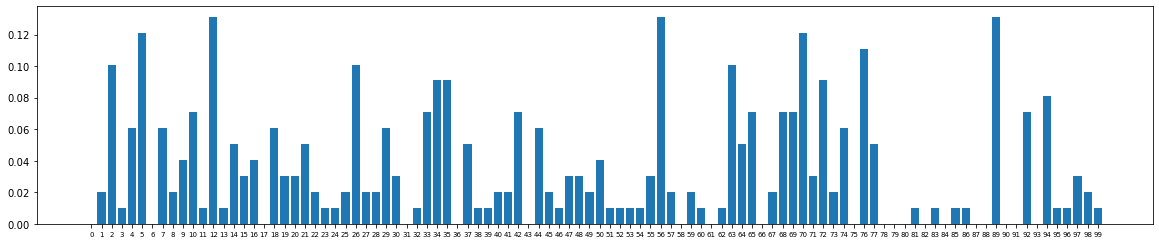

In [112]:
plt.figure(figsize=(20,4))
plt.bar(range(len(D2)), list(D2.values()), align='center')
plt.xticks(range(len(D2)), list(D2.keys()), fontsize=7)
plt.show()

max component size is 38
estimating null distribution with 500 permutations
permutation 0 of 500.  p-value so far is 0.000
permutation 50 of 500.  p-value so far is 0.000
permutation 100 of 500.  p-value so far is 0.000
permutation 150 of 500.  p-value so far is 0.000
permutation 200 of 500.  p-value so far is 0.000
permutation 250 of 500.  p-value so far is 0.000
permutation 300 of 500.  p-value so far is 0.000
permutation 350 of 500.  p-value so far is 0.000
permutation 400 of 500.  p-value so far is 0.000
permutation 450 of 500.  p-value so far is 0.000
permutation 499 of 500.  p-value so far is 0.000


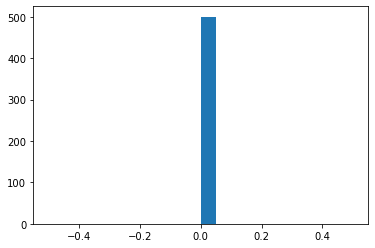

CPU times: user 2min 41s, sys: 1.19 s, total: 2min 42s
Wall time: 2min 42s


In [71]:
%%time
test3 = do_nbs(male, female, kappa=7, k=500)

In [72]:
adj3 = test3[1]

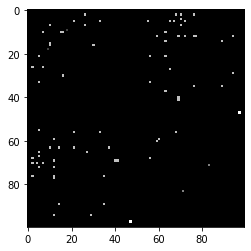

In [73]:
plt.imshow(adj3, cmap='gray')
plt.show()

max component size is 13
estimating null distribution with 500 permutations
permutation 0 of 500.  p-value so far is 0.000
permutation 50 of 500.  p-value so far is 0.000
permutation 100 of 500.  p-value so far is 0.000
permutation 150 of 500.  p-value so far is 0.000
permutation 200 of 500.  p-value so far is 0.000
permutation 250 of 500.  p-value so far is 0.000
permutation 300 of 500.  p-value so far is 0.000
permutation 350 of 500.  p-value so far is 0.000
permutation 400 of 500.  p-value so far is 0.000
permutation 450 of 500.  p-value so far is 0.000
permutation 499 of 500.  p-value so far is 0.000


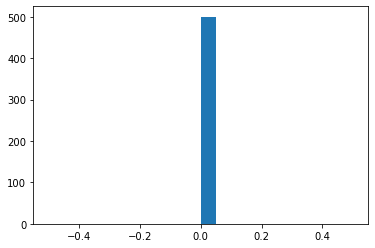

In [74]:
test4 = do_nbs(male, female, kappa=7.4, k=500)

In [75]:
adj4 = test4[1]

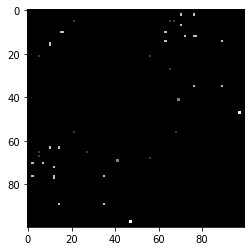

In [76]:
plt.imshow(adj4, cmap='gray')
plt.show()

In [77]:
print(adj4.sum(axis=0))
n_nodes = np.sum(adj4.sum(axis=0) > 0)
n_nodes

[0. 0. 6. 0. 0. 3. 0. 3. 0. 0. 9. 0. 9. 0. 6. 3. 3. 0. 0. 0. 0. 2. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 6. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 4.
 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 6. 0. 2. 0. 1. 1. 2. 6. 0.
 3. 0. 0. 0. 9. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 6. 0. 0. 0. 0. 0. 0.
 0. 4. 0. 0.]


25

Now we have boiled it down into 25 nodes. These nodes are based on an ICA decomposition of the brain activity, so we would have to download an additional dataset from the connectome database in order to visualize them. However, we will not do it here due to the size of the data.

#### Extra exercise 6. Find a variable of your choice in the dataframe and test for a statistical difference between two groups (e.g. for non-binary values you can binarize by setting some threshold). 
Tip: you can read more about the behavioural variables here and what the column names are in the dataframe: https://wiki.humanconnectome.org/display/PublicData/HCP+Data+Dictionary+Public-+Updated+for+the+1200+Subject+Release

In [47]:
## YOUR CODE HERE

# Autism versus healthy controls

The below code use the `nilearn.datasets` module to download fMRI scans from the Autism Brain Imaging Data Exchange (ABIDE) study and process it in a standard network-modelling pipeline using the [Yeo-2011 atlas](https://balsa.wustl.edu/W8wK) for parcellating the cortex into 17 regions. We then proceed to perform NBS to compare the autism group to matching controls.

### NB! the code below is very slow
However, this loads *raw* fMRI data and not the network matrices. fMRI data is notoriously large, and it is also fairly time consuming to process (despite *preprocessing* has already been done, so beware of having to wait some minutes.

### NB! Slow code

In [79]:
%%time
n_subjects = 20

import os
import numpy as np
from nilearn import datasets
yeo = datasets.fetch_atlas_yeo_2011()

autism = datasets.fetch_abide_pcp(n_subjects=n_subjects, DX_GROUP=1)
control = datasets.fetch_abide_pcp(n_subjects=n_subjects, DX_GROUP=2)

from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

masker = NiftiLabelsMasker(labels_img = yeo['thick_17'], standardize=True,
                           memory='nilearn_cache')
measure = ConnectivityMeasure(kind='correlation')

ts_au=[]
for func in autism.func_preproc:
    ts_au.append(masker.fit_transform(func))

ts_hc=[]
for func in control.func_preproc:
    ts_hc.append(masker.fit_transform(func))

    
corr_au = measure.fit_transform(ts_au)
corr_hc = measure.fit_transform(ts_hc)

for i, m in enumerate(corr_au):
    fn = f"abide_au{i+101}.txt"
    fn = "data/abide/" + fn
    np.savetxt(fn, m)
    
for i, m in enumerate(corr_hc):
    fn = f"abide_hc{i+101}.txt"
    fn = "data/abide/" + fn
    np.savetxt(fn, m)


/Users/arvid/opt/anaconda3/envs/bmed360v2021/lib/python3.8/site-packages/numpy/lib/npyio.py:2349: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


CPU times: user 59.9 s, sys: 4.13 s, total: 1min 4s
Wall time: 1min 3s


In [80]:
datapath = 'data/abide'

In [81]:
mats = [np.loadtxt(fn) for fn in os.scandir(path=datapath) if fn.name.startswith('abide')]
[fn.name for fn in os.scandir(datapath)]

['abide_au112.txt',
 'abide_au106.txt',
 'abide_hc115.txt',
 'abide_hc101.txt',
 'abide_hc114.txt',
 'abide_au107.txt',
 'abide_au113.txt',
 'abide_au105.txt',
 'abide_au111.txt',
 'abide_hc102.txt',
 'abide_hc116.txt',
 'abide_hc117.txt',
 'abide_hc103.txt',
 'abide_au110.txt',
 'abide_au104.txt',
 'abide_au114.txt',
 'abide_hc107.txt',
 'abide_hc113.txt',
 'abide_hc112.txt',
 'abide_hc106.txt',
 'abide_au115.txt',
 'abide_au101.txt',
 'abide_au117.txt',
 'abide_au103.txt',
 'abide_hc110.txt',
 'abide_hc104.txt',
 'abide_hc105.txt',
 'abide_hc111.txt',
 'abide_au102.txt',
 'abide_au116.txt',
 'abide_hc108.txt',
 'abide_hc120.txt',
 'abide_hc109.txt',
 'abide_au118.txt',
 'abide_au119.txt',
 'abide_au109.txt',
 'abide_au120.txt',
 'abide_au108.txt',
 'abide_hc119.txt',
 'abide_hc118.txt']

In [82]:
X = np.array(mats)
y = np.array(['au']*20 + ['hc']*20)

In [83]:
y==['au']

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [84]:
print(y.shape); print(X.shape)

(40,)
(40, 17, 17)


In [85]:
au = X[y=='au',:]
hc = X[y=='hc',:]

In [86]:
au.T.shape

(17, 17, 20)

In [87]:
kappa = 0.8
pval, adj, null = nbs.nbs_bct(au.T, hc.T, kappa)

max component size is 83
estimating null distribution with 1000 permutations
permutation 0 of 1000.  p-value so far is 0.000
permutation 100 of 1000.  p-value so far is 0.198
permutation 200 of 1000.  p-value so far is 0.244
permutation 300 of 1000.  p-value so far is 0.249
permutation 400 of 1000.  p-value so far is 0.224
permutation 500 of 1000.  p-value so far is 0.232
permutation 600 of 1000.  p-value so far is 0.221
permutation 700 of 1000.  p-value so far is 0.208
permutation 800 of 1000.  p-value so far is 0.210
permutation 900 of 1000.  p-value so far is 0.203
permutation 999 of 1000.  p-value so far is 0.204


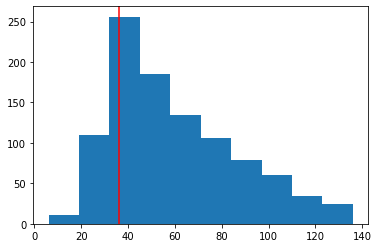

In [88]:
plt.hist(null)
plt.axvline(36, c='red')
plt.show()

max component size is 112
estimating null distribution with 1000 permutations
permutation 0 of 1000.  p-value so far is 0.000
permutation 100 of 1000.  p-value so far is 0.287
permutation 200 of 1000.  p-value so far is 0.274
permutation 300 of 1000.  p-value so far is 0.272
permutation 400 of 1000.  p-value so far is 0.292
permutation 500 of 1000.  p-value so far is 0.309
permutation 600 of 1000.  p-value so far is 0.309
permutation 700 of 1000.  p-value so far is 0.305
permutation 800 of 1000.  p-value so far is 0.302
permutation 900 of 1000.  p-value so far is 0.311
permutation 999 of 1000.  p-value so far is 0.310


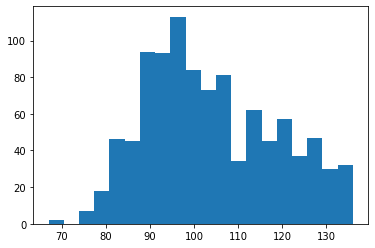

[0.31]


In [89]:
pval, adj, null = do_nbs(au.T, hc.T, kappa=0.3)
print(pval)

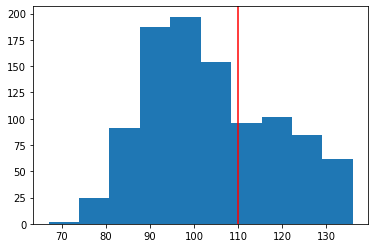

In [90]:
plt.hist(null)
plt.axvline(110, c='red')
plt.show()

## Summary and conclusion
We could identify no difference in the connectome between those with ADHD and controls with this setup. It might be unexpected that we don't observe any difference, but we must consider three factors: i) our data set is only 40 (compared to 800 in the first dataset), making it harder to detect any effect, ii) we used a very rough parcellation of only 17 nodes (compared to 100), again compromising sensitivity, and iii) the parcellation is based on predefined regions anatomically rather than mined from the brain activity itself (ICA). This scheme is simpler but vulnerable to functionally meaningless segmentation.

## Pros and cons of NBS

**Pros**
* It let's you easily test hypotheses about group differences in networks (e.g. connectomes between sick and healthy).
* You can identify edges disturbed by disease

* There is no difficult math (non-parametric)
* It deals naturally with the graph structure
- it increases statistical power compared to other methods of multiple testing

**Cons**
* It is hard to interpret what the difference actually is
* There is no obvious "right" value for the threshold (kappa)
* It is computationally heavy (like all permutation tests)